In [33]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

import sys
sys.path.insert(0,'..')
import jabble.model

In [34]:
def heavyside(x,c1,c2):
    
    return ((x > c1) * (x < c2)).astype(float)

x_grid = np.linspace(-2,2)
t = np.linspace(0,10000000,10)

In [35]:
def func(x,t,j,p):
    
    return heavyside(x,0,1) * (heavyside(x - t,(j-1)/(p-1),j/(p-1)) - heavyside(x + t,(j-1)/(p-1),j/(p-1)))

In [36]:
def firstalpha(x,t):
    
    return t * heavyside(x-t,0,1) * heavyside(t,0,1)

In [37]:
ys = np.array([firstalpha(x_grid,tp) for tp in t])

In [38]:
a2 = jnp.convolve(heavyside(x_grid,0,1),heavyside(x_grid,0,1),'same')

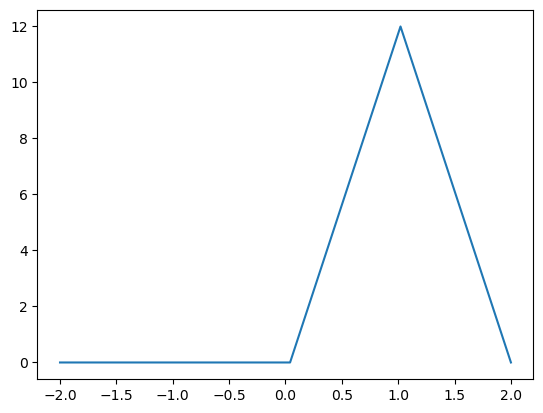

In [39]:
plt.plot(x_grid,a2)
plt.show()

In [40]:
def convolve_recurrence(x_grid,p):
    temp = heavyside(x_grid,-1/2,1/2)
    for i in range(p):
        temp = jnp.convolve(temp,heavyside(x_grid,-1/2,1/2),'same')
        
    return temp

In [16]:
def convidentity(x,t):
    
    return t*(heavyside(x,-1/2+t,1/2+t) - heavyside(x + t,-1/2,1/2))

In [17]:
t = np.linspace(-100,100,11)
xs = np.linspace(-100,100,10000)
ys = np.array([convidentity(xs,tp) for tp in t])

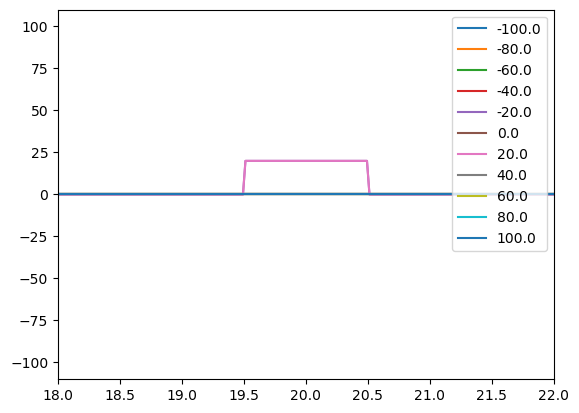

In [18]:
for i in range(ys.shape[0]):
    plt.plot(xs,ys[i,:],label='{}'.format(t[i]))
plt.xlim(18,22)
plt.legend()
plt.show()

In [19]:
def _new_alpha_recursion(i,j,p):
    if i <= 0 or i > p:
        return 0
    if j <= 0 or j > p:
        return 0
    if p == 0:
        return 1
    
    return _new_alpha_recursion(i-1,j-1,p-1)/i - _new_alpha_recursion(i-1,j,p-1)/i

In [20]:
# def new_bsplinefunc(x,p):
# #     print(p)
#     alphas = np.zeros((p+1,p+1))
#     for i in range(p+1):
#         for j in range(p+1):
#             alphas[i,j] = _new_alpha_recursion(i,j,p)
#     print(alphas)
#     alphas = jnp.array(alphas)
#     j = jnp.floor(x + (p+1) / 2).astype(int)
#     cond1 = j >= 0
#     cond2 = j <= p
    
# #     print(np.unique(j))
#     f = jnp.where((cond1 * cond2), jnp.polyval(alphas[::-1,j], (x + (p+1) / 2) - j), 0.0)
#     return f

In [22]:
import math

In [23]:
def _irwin_recursion(j,k,n):
    if k == 0:
        if j < n-1:
            return 0.0
        else:
            return 1.0
    
    return _irwin_recursion(j,k-1,n) + ((-1)**(n+k-j-1) * math.comb(n,k) * math.comb(n-1,j) * k**(n-j-1))

In [120]:
class IrwinHall:
    def __init__(self,n):
        n +=1
        self.n = n
        self.alphas = np.zeros((n,n))
        for j in range(n):
            for k in range(n):
                self.alphas[j,k] = _irwin_recursion(j,k,n)
        self.alphas = jnp.array(self.alphas)
        
    def __call__(self,x,*args):
        ks = np.floor(x + (self.n/2)).astype(int)
        cond1 = ks >= 0
        cond2 = ks <= (self.n-1)
        f = jnp.where((cond1 * cond2), \
                      jnp.polyval(self.alphas[::-1,ks],x + (self.n/2)), \
                      0.0)
        
        return f
    

In [121]:
n = 2
basis_spline = IrwinHall(n)

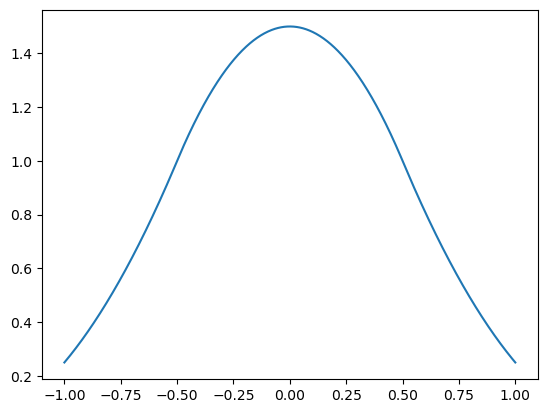

In [122]:
x_grid = np.linspace(-((n)/2),(n)/2,1000)
plt.plot(x_grid,basis_spline(x_grid))
plt.show()

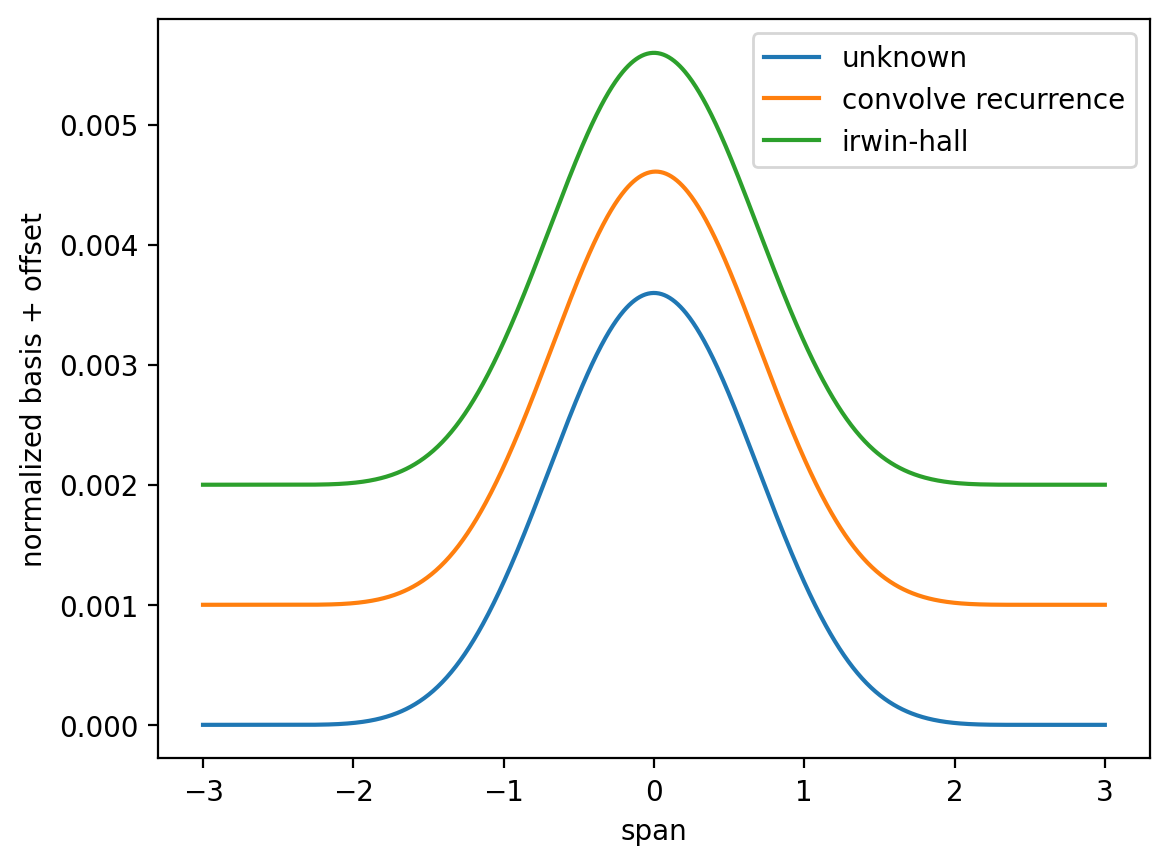

In [123]:
p=4
plt.figure(dpi=200,facecolor=(1,1,1))
x_grid = np.linspace(-((p+2)/2),(p+2)/2,1000)
unknown_spline = jabble.model.BSpline(p)
temp = unknown_spline(x_grid)
temp = temp/np.sum(temp)
plt.plot(x_grid,temp,label='unknown')

temp = convolve_recurrence(x_grid,p)
temp = temp/np.sum(temp)
plt.plot(x_grid,temp+0.001,label='convolve recurrence')

basis_spline = IrwinHall(p)
temp = basis_spline(x_grid)
temp = temp/np.sum(temp)
plt.plot(x_grid,temp+0.002,label='irwin-hall')
plt.legend()
plt.ylabel('normalized basis + offset')
plt.xlabel('span')
plt.savefig('../out/basis_comp_p{}.png'.format(p))
plt.show()

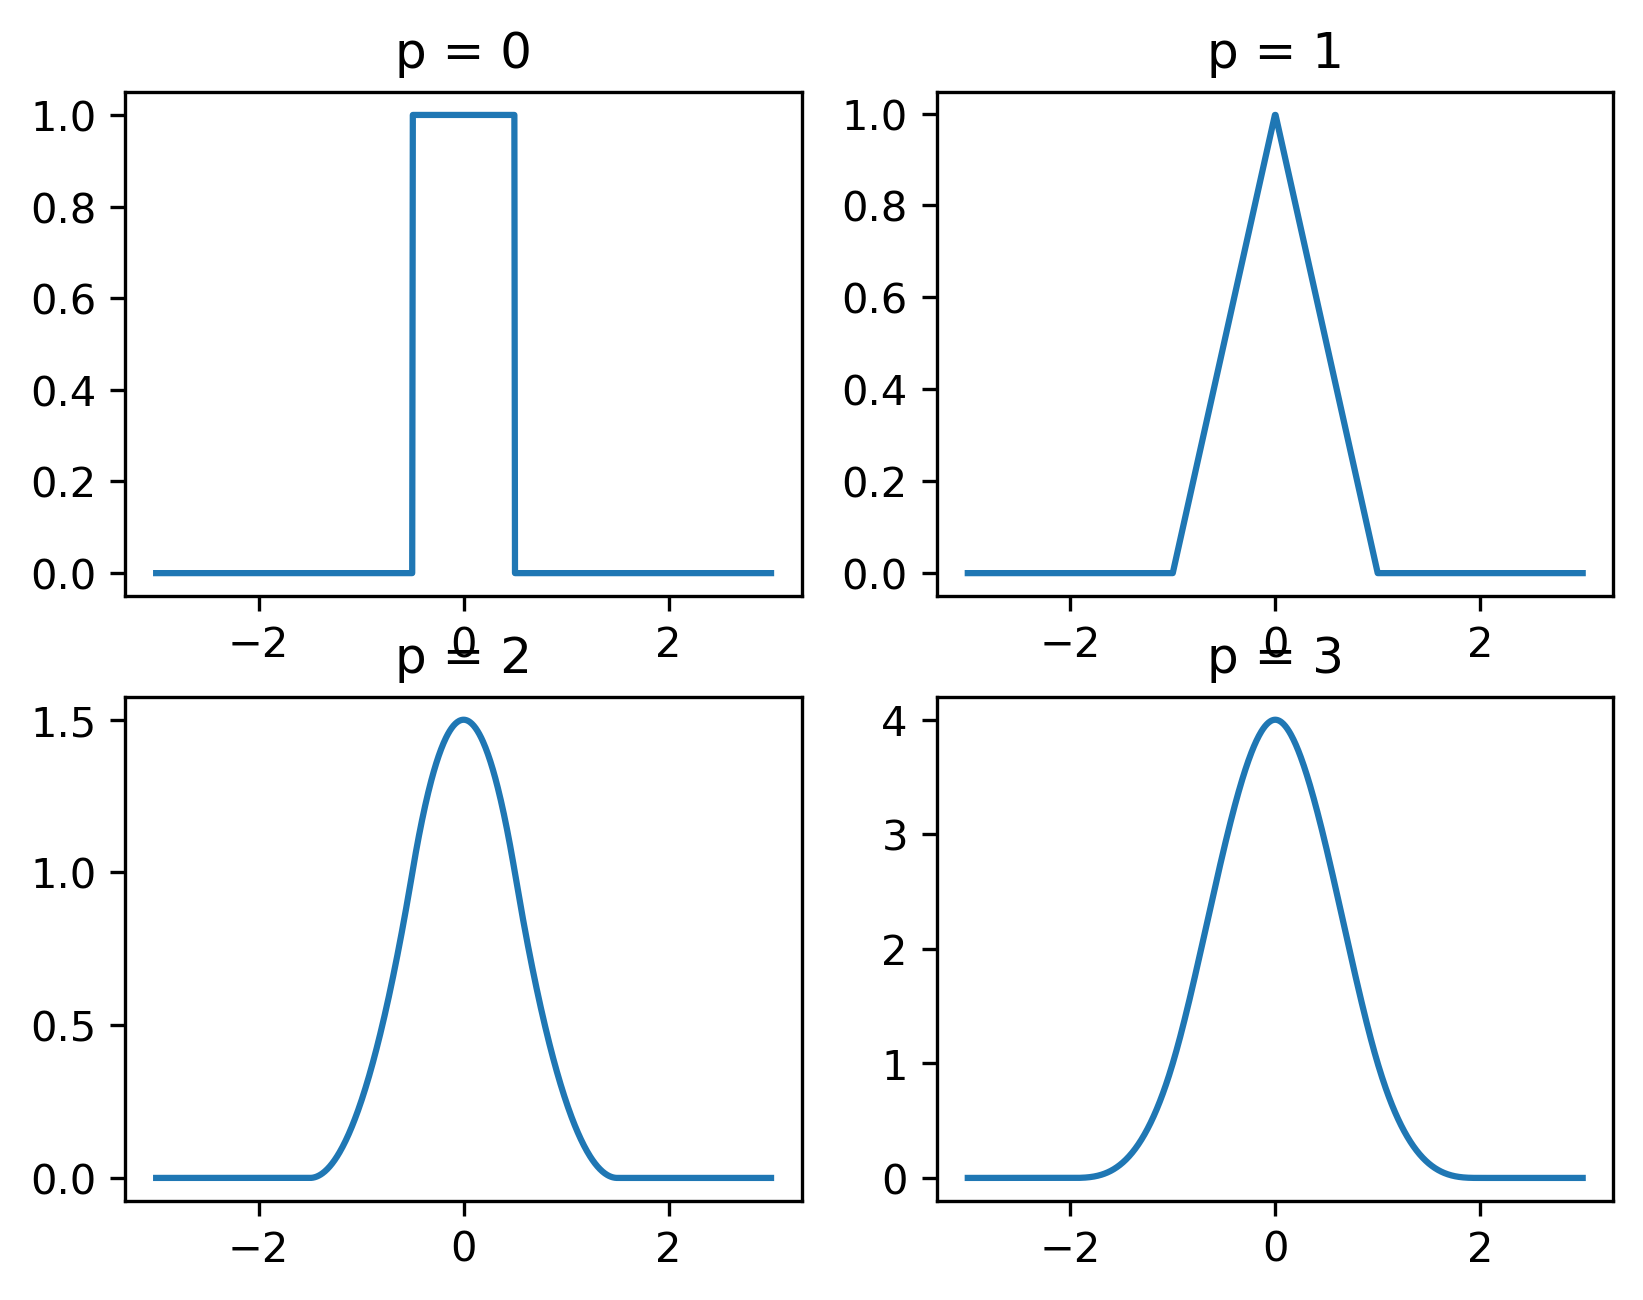

In [124]:
fig, axes = plt.subplots(2,2,dpi=300,facecolor=(1,1,1))
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        p =( i) * axes.shape[0] + j%axes.shape[1]
#         print(p)
        basis_spline = IrwinHall(p)
        temp = basis_spline(x_grid)
    # temp = temp/np.sum(temp)
        axes[i,j].plot(x_grid,temp)
        axes[i,j].set_title('p = {}'.format(p))
# plt.ylabel('normalized basis')
# plt.xlabel('span')
plt.savefig('../out/basis_comp_p{}.png'.format(p))
plt.show()